In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/cse519

Mounted at /content/drive
/content/drive/MyDrive/cse519


In [ ]:
!curl ipecho.net/plain

34.133.60.86

In [ ]:
## packages
!pip install -q kaggle
!pip install -q pandas
!pip install -q scikit-learn
!pip install -q numpy
!pip install -q Matplotlib
!pip install -q seaborn

In [ ]:
from google.colab import files
files.upload()

{}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle competitions download -c optiver-trading-at-the-close
!unzip optiver-trading-at-the-close.zip
!ls

mkdir: cannot create directory ‘/root/.kaggle’: File exists
100% 201M/201M [00:01<00:00, 135MB/s]
100% 201M/201M [00:01<00:00, 126MB/s]
Archive:  optiver-trading-at-the-close.zip
  inflating: example_test_files/revealed_targets.csv  
  inflating: example_test_files/sample_submission.csv  
  inflating: example_test_files/test.csv  
  inflating: optiver2023/__init__.py  
  inflating: optiver2023/competition.cpython-310-x86_64-linux-gnu.so  
  inflating: public_timeseries_testing_util.py  
  inflating: train.csv               
example_test_files  optiver2023			      public_timeseries_testing_util.py
kaggle.json	    optiver-trading-at-the-close.zip  train.csv


In [ ]:
# Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
from sklearn.model_selection import cross_val_score, KFold, TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
import numpy as np
from scipy.stats import mstats
import sys
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor

#### Anomalies and Cleaning


In [ ]:
col_names = [
  "stock_id",
  "date_id",
  "seconds_in_bucket",
  "imbalance_size",
  "imbalance_buy_sell_flag",
  "reference_price",
  "matched_size",
  "far_price",
  "near_price",
  "bid_price",
  "bid_size",
  "ask_price",
  "ask_size",
  "wap",
  "target",
  "time_id",
  "row_id"
]
dtypes = {
  "stock_id": np.int,
  "date_id":np.int,
  "seconds_in_bucket":np.int,
  "imbalance_size":np.float64,
  "imbalance_buy_sell_flag":np.int,
  "reference_price":np.float64,
  "matched_size":np.float64,
  "far_price":np.float64,
  "near_price":np.float64,
  "bid_price":np.float64,
  "bid_size":np.float64,
  "ask_price":np.float64,
  "ask_size":np.float64,
  "wap":np.float64,
  "target":np.float64,
  "time_id":np.int,
  "row_id": "string",
}
csv = pd.read_csv("train.csv")


<ipython-input-4-9379ef57ad81>:21: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  "stock_id": np.int,
<ipython-input-4-9379ef57ad81>:22: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and

In [ ]:
def df_stats(df):
    result = pd.DataFrame({
        'unique': df.nunique() == len(df),
        'cardinality': df.nunique(),
        'null_ct': df.isna().sum(),
        'null_pct': round((df.isnull().sum() / len(df)) * 100, 2),
        '1st_row': df.iloc[0],
        'random_row': df.iloc[np.random.randint(low=0, high=len(df))],
        'last_row': df.iloc[-1],
        'min': df.min(),
        '1%': df.quantile(0.01),
        '10%': df.quantile(0.1),
        '25%': df.quantile(0.25),
        '50%': df.quantile(0.5),
        '75%': df.quantile(0.75),
        '90%': df.quantile(0.9),
        '99%': df.quantile(0.99),
        'max': df.max(),
        'dtype': df.dtypes,
    })
    return result

In [ ]:
df_stats(csv)

<ipython-input-5-2c52299cc972>:11: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  '1%': df.quantile(0.01),
<ipython-input-5-2c52299cc972>:12: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  '10%': df.quantile(0.1),
<ipython-input-5-2c52299cc972>:13: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  '25%': df.quantile(0.25),
<ipython-input-5-2c52299cc972>:14: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will 

,unique,cardinality,null_ct,null_pct,1st_row,random_row,last_row,min,1%,10%,25%,50%,75%,90%,99%,max,dtype
ask_price,False,28266,220,0.00,1.000026,1.000914,1.002447,0.939827,0.993745,9.975610e-01,9.990290e-01,1.000207e+00,1.001414e+00,1.002997e+00,1.007501e+00,1.077836,float64
ask_size,False,2623254,0,0.00,8493.03,1800.8,300167.56,0.0,171.147900,2.054430e+03,7.823700e+03,2.301792e+04,5.787841e+04,1.292730e+05,4.454793e+05,54405000.0,float64
bid_price,False,28313,220,0.00,0.999812,1.000736,1.002129,0.934915,0.992991,9.969990e-01,9.985290e-01,9.997280e-01,1.000905e+00,1.002420e+00,1.006707e+00,1.077488,float64
bid_size,False,2591773,0,0.00,60651.5,31508.4,250081.44,0.0,165.460000,1.872310e+03,7.374720e+03,2.196900e+04,5.583168e+04,1.259336e+05,4.404421e+05,30287840.0,float64
date_id,False,481,0,0.00,0,475,480,0,4.000000,4.900000e+01,1.220000e+02,2.420000e+02,3.610000e+02,4.330000e+02,4.760000e+02,480,int64
far_price,False,95739,2894342,55.26,NaN,NaN,1.000859,0.000077,0.947591,9.840900e-01,9.963320e-01,9.998830e-01,1.003318e+00,1.014392e+00,1.052688e+00,437.9531,float64
imbalance_buy_sell_flag,False,3,0,0.00,1,1,-1,-1,-1.000000,-1.000000e+00,-1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1,int64
imbalance_size,False,2971863,220,0.00,3180602.69,1497572.78,1884285.71,0.0,0.000000,0.000000e+00,8.453415e+04,1.113604e+06,4.190951e+06,1.232748e+07,7.636496e+07,2982027811.68,float64
matched_size,False,2948862,220,0.00,13380276.64,13210530.49,24073677.32,4316.61,463873.450900,2.332147e+06,5.279575e+06,1.288264e+07,3.270013e+07,9.025021e+07,6.151657e+08,7713682054.05,float64
near_price,False,84625,2857180,54.55,NaN,NaN,1.001494,0.786988,0.956499,9.907730e-01,9.971000e-01,9.998890e-01,1.002590e+00,1.008161e+00,1.038481e+00,1.309732,float64


In [ ]:
grouped = csv.groupby(['stock_id', 'date_id'])
result = grouped['seconds_in_bucket'].size().reset_index(name='count')
print("Total number of stock, date groups:", result.shape[0])

filtered_result = result[result['count'] != 55]
print("Number of groups with incomplete timeseries data:", filtered_result.shape[0])

initial_wap = csv[csv['seconds_in_bucket'] == 0]['wap']
print("Number of records with initial wap as NA:", initial_wap.isnull().sum())

result = grouped[['far_price', 'near_price']].apply(lambda x: x.isna().all().any())

# Get the groups where either 'far_price' or 'near_price' is NA for the entire group
groups_with_na_prices = result[result].index

print("Stock, date groups with either far_price or near_price null for the entire timeseries:")
print(groups_with_na_prices)

# Dropping the records belonging to those groups
csv = csv[~csv.set_index(['stock_id', 'date_id']).index.isin(groups_with_na_prices)]

df_stats(csv)

Total number of stock, date groups: 95236
Number of groups with incomplete timeseries data: 0
Number of records with initial wap as NA: 4
Stock, date groups with either far_price or near_price null for the entire timeseries:
MultiIndex([( 19, 438),
            ( 31, 321),
            ( 31, 418),
            ( 31, 431),
            ( 31, 451),
            ( 31, 459),
            ( 31, 460),
            ( 31, 475),
            ( 31, 476),
            ( 78,  21),
            ( 78,  60),
            ( 78,  86),
            (101, 328),
            (129,  70),
            (131,  35),
            (143, 177),
            (143, 209),
            (143, 215),
            (143, 230),
            (143, 277),
            (143, 449),
            (143, 467),
            (143, 477),
            (158, 388)],
           names=['stock_id', 'date_id'])


<ipython-input-5-2c52299cc972>:11: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  '1%': df.quantile(0.01),
<ipython-input-5-2c52299cc972>:12: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  '10%': df.quantile(0.1),
<ipython-input-5-2c52299cc972>:13: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  '25%': df.quantile(0.25),
<ipython-input-5-2c52299cc972>:14: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will 

,unique,cardinality,null_ct,null_pct,1st_row,random_row,last_row,min,1%,10%,25%,50%,75%,90%,99%,max,dtype
ask_price,False,28245,0,0.00,1.000026,0.998832,1.002447,0.939827,0.993746,9.975610e-01,9.990290e-01,1.000207e+00,1.001414e+00,1.002996e+00,1.007498e+00,1.077836,float64
ask_size,False,2622604,0,0.00,8493.03,199235.2,300167.56,0.59,171.280000,2.055510e+03,7.824050e+03,2.301583e+04,5.786320e+04,1.292208e+05,4.451566e+05,54405000.0,float64
bid_price,False,28298,0,0.00,0.999812,0.998647,1.002129,0.934915,0.992993,9.970000e-01,9.985290e-01,9.997280e-01,1.000905e+00,1.002420e+00,1.006705e+00,1.077488,float64
bid_size,False,2591119,0,0.00,60651.5,50124.38,250081.44,0.56,165.640000,1.873100e+03,7.375000e+03,2.196675e+04,5.581700e+04,1.258772e+05,4.403466e+05,30287840.0,float64
date_id,False,481,0,0.00,0,92,480,0,4.000000,4.900000e+01,1.220000e+02,2.420000e+02,3.610000e+02,4.330000e+02,4.760000e+02,480,int64
far_price,False,95739,2893022,55.25,NaN,0.951786,1.000859,0.000077,0.947591,9.840900e-01,9.963320e-01,9.998830e-01,1.003318e+00,1.014392e+00,1.052688e+00,437.9531,float64
imbalance_buy_sell_flag,False,3,0,0.00,1,-1,-1,-1,-1.000000,-1.000000e+00,-1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1,int64
imbalance_size,False,2971496,0,0.00,3180602.69,5683707.33,1884285.71,0.0,0.000000,0.000000e+00,8.447035e+04,1.113979e+06,4.191736e+06,1.232985e+07,7.637602e+07,2982027811.68,float64
matched_size,False,2948546,0,0.00,13380276.64,61338172.3,24073677.32,4316.61,467986.730000,2.335459e+06,5.283528e+06,1.288707e+07,3.270830e+07,9.026745e+07,6.152337e+08,7713682054.05,float64
near_price,False,84618,2856360,54.55,NaN,0.951786,1.001494,0.786988,0.956500,9.907730e-01,9.971010e-01,9.998890e-01,1.002589e+00,1.008159e+00,1.038471e+00,1.309732,float64


In [ ]:
old_csv = csv.copy()

"""
From the Optiver dataset description:
All price related columns are converted to a price move relative to the stock wap (weighted average price) at the beginning of the auction period.
Therefore, the initial value of wap at the start of the closing auction will always be 1. However, there were 4 NA values as shown above.
Replacing that with 1, before forward filling the rest of the values.

Note: This is no longer needed as dropping timeseries with all null values for far_price/near_price removed these anomalies.
"""
# csv.loc[csv['seconds_in_bucket'] == 0, 'wap'] = 1

"""
Using forward fill to replace the missing values in the following columns.
But since this is timeseries data wrt only a particular stock and day, we first group the rows, and then forward fill
There are null values left even after forwardfill, which is handled by backward fill.

Note: This is no longer needed as dropping timeseries with all null values for far_price/near_price removed these anomalies.
"""
# grouped = csv.groupby(['stock_id', 'date_id'])
# na_columns = ['imbalance_size', 'reference_price', 'matched_size', 'bid_price', 'ask_price', 'wap', 'target']
# csv[na_columns] = grouped[na_columns].transform(lambda x: x.fillna(method="ffill")).transform(lambda x: x.fillna(method="bfill"))

last5mins = ['near_price', 'far_price']
csv[last5mins] = grouped[last5mins].transform(lambda x: x.fillna(x.mean()))

# Using one hot encoding to convert the categorical imbalance_buy_sell_flag into two boolean columns (buy/sell)_imbalance
csv["buy_imbalance"] = (csv['imbalance_buy_sell_flag'] == 1).astype(int)
csv["sell_imbalance"] = (csv['imbalance_buy_sell_flag'] == -1).astype(int)
csv.drop('imbalance_buy_sell_flag', axis=1, inplace=True)

# Adding price_spread as a new feature
csv['price_spread'] = (csv['bid_price']-csv['ask_price']).abs()

df_stats(csv)

<ipython-input-7-0993d4618a1c>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  csv[last5mins] = grouped[last5mins].transform(lambda x: x.fillna(x.mean()))
<ipython-input-7-0993d4618a1c>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  csv["buy_imbalance"] = (csv['imbalance_buy_sell_flag'] == 1).astype(int)
<ipython-input-7-0993d4618a1c>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

,unique,cardinality,null_ct,null_pct,1st_row,random_row,last_row,min,1%,10%,25%,50%,75%,90%,99%,max,dtype
ask_price,False,28245,0,0.0,1.000026,1.001456,1.002447,0.939827,0.993746,9.975610e-01,9.990290e-01,1.000207e+00,1.001414e+00,1.002996e+00,1.007498e+00,1.077836,float64
ask_size,False,2622604,0,0.0,8493.03,653.48,300167.56,0.59,171.280000,2.055510e+03,7.824050e+03,2.301583e+04,5.786320e+04,1.292208e+05,4.451566e+05,54405000.0,float64
bid_price,False,28298,0,0.0,0.999812,1.000598,1.002129,0.934915,0.992993,9.970000e-01,9.985290e-01,9.997280e-01,1.000905e+00,1.002420e+00,1.006705e+00,1.077488,float64
bid_size,False,2591119,0,0.0,60651.5,14364.24,250081.44,0.56,165.640000,1.873100e+03,7.375000e+03,2.196675e+04,5.581700e+04,1.258772e+05,4.403466e+05,30287840.0,float64
buy_imbalance,False,2,0,0.0,1,1,0,0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1,int64
date_id,False,481,0,0.0,0,159,480,0,4.000000,4.900000e+01,1.220000e+02,2.420000e+02,3.610000e+02,4.330000e+02,4.760000e+02,480,int64
far_price,False,188318,0,0.0,0.999692,1.01963,1.000859,0.000077,0.949310,9.835400e-01,9.952981e-01,9.998690e-01,1.004257e+00,1.015419e+00,1.051106e+00,437.9531,float64
imbalance_size,False,2971496,0,0.0,3180602.69,5330191.3,1884285.71,0.0,0.000000,0.000000e+00,8.447035e+04,1.113979e+06,4.191736e+06,1.232985e+07,7.637602e+07,2982027811.68,float64
matched_size,False,2948546,0,0.0,13380276.64,27532198.29,24073677.32,4316.61,467986.730000,2.335459e+06,5.283528e+06,1.288707e+07,3.270830e+07,9.026745e+07,6.152337e+08,7713682054.05,float64
near_price,False,176247,0,0.0,0.999615,1.013469,1.001494,0.786988,0.964305,9.902148e-01,9.967620e-01,9.998736e-01,1.002844e+00,1.008712e+00,1.033486e+00,1.309732,float64


1.   Row_ids are unique - so there are no duplicates.

2.   Seconds in bucket ranges from 0-540 representing the 10 minutes in 10 second intervals, except for the last 20 seconds.

3.   Dataset - We have data for 200 stocks (0-199), for 481 days (0-480), for 55 10 second intervals(0-540 total of 10 minutes - last 20 seconds). So we'd expect to see 5291000(200*481*55) records, but only 5237980 records are given (Missing 53020 data points).
Further analysis shows that there are total 95236 combinations of (stock_id and date_id) and each group has 55 records(complete time-series). Since in the dataset they have mentioned that not all stocks will be present on all days, these numbers make sense. They are not missing any data.

4.   There are lots of null values - which needs to be handled. The columns with null values are - imbalance_size, reference_price, matched_size, bid_price, ask_price, wap. SInce this is timeseries data, dropping the rows would result in missing steps. It might be better to interpolate the missing values or simply forward fill(so that we don't have to assume what happened in that step)

5.   Target has 88 missing values - forward filling for now, will try with interpolation later on.
> Note: Far price and near price have a lot of null values - but that is expected. Nasdaq releases those prices only 5 minutes before the closing, therefore about 55% of the values are null for both.

Note: After more exploration, groups (stock_id, date_id) with null far_time or near_time for all the records in the timeseries were found. Since there is no way to impute those missing values without assumptions, those 24 groups have been dropped. Dropping these anomalous timeseries resolved the other missing values.

6.   Outliers: ask_size, bid_size, imbalance_size has huge outliers, which could indicate a peak in market volume for those periods. Removing those records will make the time-series incomplete. If we bound it to a maximum value, we might lose information about some market trend. Perhaps while normalizing the values, we can make the ask_size, bid_size, imbalance_size and matched_size relative to each other.



---



#### Pairwise Correlation Table and Explaition


In [ ]:
def pearson_correlation_stats(df):
  corr_matrix = df.corr() #Default is Pearson
  display(HTML(corr_matrix.to_html()))

  mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

  sorted_correlations = corr_matrix.unstack().sort_values() # Masking the redundant half
  sorted_correlations = sorted_correlations[sorted_correlations != 1] # Removing all self-correlations

  # Any correlation with an absolute value in the range of 0 to 0.1 indicates a very very weak linear relation and is hence not considered.
  top_correlations = sorted_correlations[sorted_correlations >= 0.1]
  least_correlations = sorted_correlations[sorted_correlations <= -0.1]

  print("\n\nTop Correlations:")
  print(top_correlations)
  print("\n\nLeast 10 Correlations:")
  print(least_correlations)

  plt.figure(figsize=(14, 14))
  sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, mask=mask)
  plt.title('Correlation Matrix Heatmap')
  plt.show()

<ipython-input-8-4a31b9bbe7a3>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr() #Default is Pearson


,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id
stock_id,1.000000e+00,5.146092e-03,-5.032657e-16,0.024630,0.004147,-0.000724,0.035120,-0.000831,0.004797,0.004271,0.032871,-0.006333,0.027030,-0.000652,0.000127,0.005146
date_id,5.146092e-03,1.000000e+00,-1.075560e-13,0.006478,-0.010666,-0.006329,0.000560,-0.003004,-0.016253,-0.006215,0.024687,-0.006876,0.018592,-0.006646,0.000950,0.999998
seconds_in_bucket,-5.032657e-16,-1.075560e-13,1.000000e+00,-0.123959,-0.003618,-0.000844,0.068633,-0.000550,0.017641,0.014823,0.162877,-0.017839,0.146394,-0.001269,-0.002246,0.002084
imbalance_size,2.462988e-02,6.478015e-03,-1.239586e-01,1.000000,-0.010138,-0.003711,0.512360,0.000523,-0.030910,0.005659,0.021180,-0.012753,0.022674,-0.003503,-0.001186,0.006220
imbalance_buy_sell_flag,4.146898e-03,-1.066608e-02,-3.617541e-03,-0.010138,1.000000,0.182077,-0.005981,0.018010,0.508814,0.129730,0.035269,0.132515,-0.013358,0.133895,0.015101,-0.010674
reference_price,-7.237056e-04,-6.329082e-03,-8.440993e-04,-0.003711,0.182077,1.000000,0.007745,0.015349,0.473744,0.983806,0.007351,0.985122,-0.006556,0.988173,-0.017462,-0.006331
matched_size,3.512030e-02,5.601182e-04,6.863252e-02,0.512360,-0.005981,0.007745,1.000000,-0.000705,-0.002711,0.023544,0.078612,-0.007231,0.079290,0.008286,0.000206,0.000703
far_price,-8.311000e-04,-3.004471e-03,-5.499413e-04,0.000523,0.018010,0.015349,-0.000705,1.000000,0.031519,0.014327,0.002229,0.014671,-0.000153,0.014643,-0.001804,-0.003005
near_price,4.797222e-03,-1.625306e-02,1.764079e-02,-0.030910,0.508814,0.473744,-0.002711,0.031519,1.000000,0.458671,0.032204,0.460535,-0.013297,0.462772,0.006037,-0.016236
bid_price,4.271108e-03,-6.214720e-03,1.482348e-02,0.005659,0.129730,0.983806,0.023544,0.014327,0.458671,1.000000,-0.000909,0.973148,-0.008325,0.989332,-0.022403,-0.006184




Top Correlations:
imbalance_buy_sell_flag  bid_price                  0.129730
bid_price                imbalance_buy_sell_flag    0.129730
ask_price                imbalance_buy_sell_flag    0.132515
imbalance_buy_sell_flag  ask_price                  0.132515
                         wap                        0.133895
wap                      imbalance_buy_sell_flag    0.133895
ask_size                 seconds_in_bucket          0.146394
seconds_in_bucket        ask_size                   0.146394
bid_size                 seconds_in_bucket          0.162877
seconds_in_bucket        bid_size                   0.162877
imbalance_buy_sell_flag  reference_price            0.182077
reference_price          imbalance_buy_sell_flag    0.182077
ask_size                 bid_size                   0.278207
bid_size                 ask_size                   0.278207
near_price               bid_price                  0.458671
bid_price                near_price                 0.458671
ask_

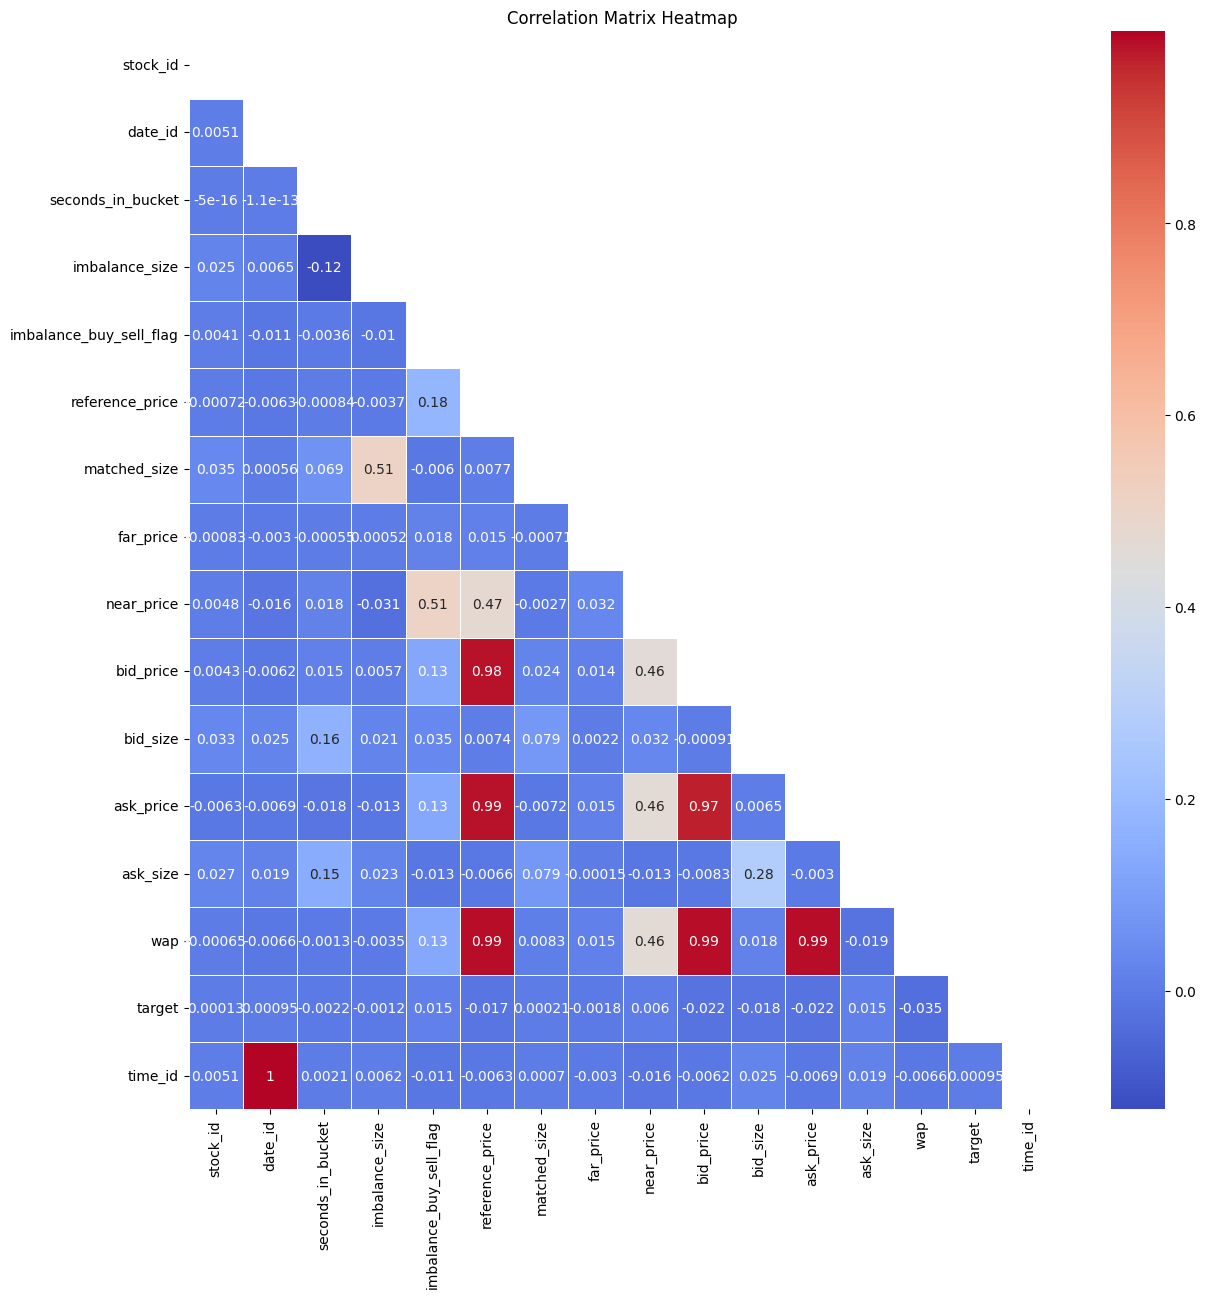

In [ ]:
# For the original dataset
pearson_correlation_stats(old_csv)

,seconds_in_bucket,imbalance_size,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,buy_imbalance,sell_imbalance,price_spread
seconds_in_bucket,1.000000,-0.123959,-0.000844,0.068633,-0.000538,0.003965,0.014823,0.162877,-0.017839,0.146394,-0.001269,-0.002246,-0.079867,-0.072892,-0.140949
imbalance_size,-0.123959,1.000000,-0.003711,0.512360,-0.000130,-0.011046,0.005659,0.021180,-0.012753,0.022674,-0.003503,-0.001186,0.052605,0.070658,-0.079505
reference_price,-0.000844,-0.003711,1.000000,0.007745,0.015742,0.390027,0.983806,0.007351,0.985122,-0.006556,0.988173,-0.017462,0.166594,-0.163633,0.024227
matched_size,0.068633,0.512360,0.007745,1.000000,-0.001335,-0.002089,0.023544,0.078612,-0.007231,0.079290,0.008286,0.000206,0.028010,0.038677,-0.132619
far_price,-0.000538,-0.000130,0.015742,-0.001335,1.000000,0.036864,0.014430,0.002954,0.015073,0.000892,0.014925,0.005344,0.016064,-0.013757,0.003049
near_price,0.003965,-0.011046,0.390027,-0.002089,0.036864,1.000000,0.373579,0.024098,0.376508,-0.008465,0.378490,0.113894,0.339855,-0.347488,0.019702
bid_price,0.014823,0.005659,0.983806,0.023544,0.014430,0.373579,1.000000,-0.000909,0.973148,-0.008325,0.989332,-0.022403,0.121440,-0.113861,-0.097264
bid_size,0.162877,0.021180,0.007351,0.078612,0.002954,0.024098,-0.000909,1.000000,0.006480,0.278207,0.018142,-0.017998,0.028159,-0.035785,0.031928
ask_price,-0.017839,-0.012753,0.985122,-0.007231,0.015073,0.376508,0.973148,0.006480,1.000000,-0.003030,0.988992,-0.021712,0.119958,-0.120373,0.134436
ask_size,0.146394,0.022674,-0.006556,0.079290,0.000892,-0.008465,-0.008325,0.278207,-0.003030,1.000000,-0.018648,0.014953,-0.015525,0.008720,0.022736




Top Correlations:
target             near_price           0.113894
near_price         target               0.113894
ask_price          buy_imbalance        0.119958
buy_imbalance      ask_price            0.119958
bid_price          buy_imbalance        0.121440
buy_imbalance      bid_price            0.121440
wap                buy_imbalance        0.123313
buy_imbalance      wap                  0.123313
ask_price          price_spread         0.134436
price_spread       ask_price            0.134436
ask_size           seconds_in_bucket    0.146394
seconds_in_bucket  ask_size             0.146394
bid_size           seconds_in_bucket    0.162877
seconds_in_bucket  bid_size             0.162877
buy_imbalance      reference_price      0.166594
reference_price    buy_imbalance        0.166594
ask_size           bid_size             0.278207
bid_size           ask_size             0.278207
buy_imbalance      near_price           0.339855
near_price         buy_imbalance        0.339855


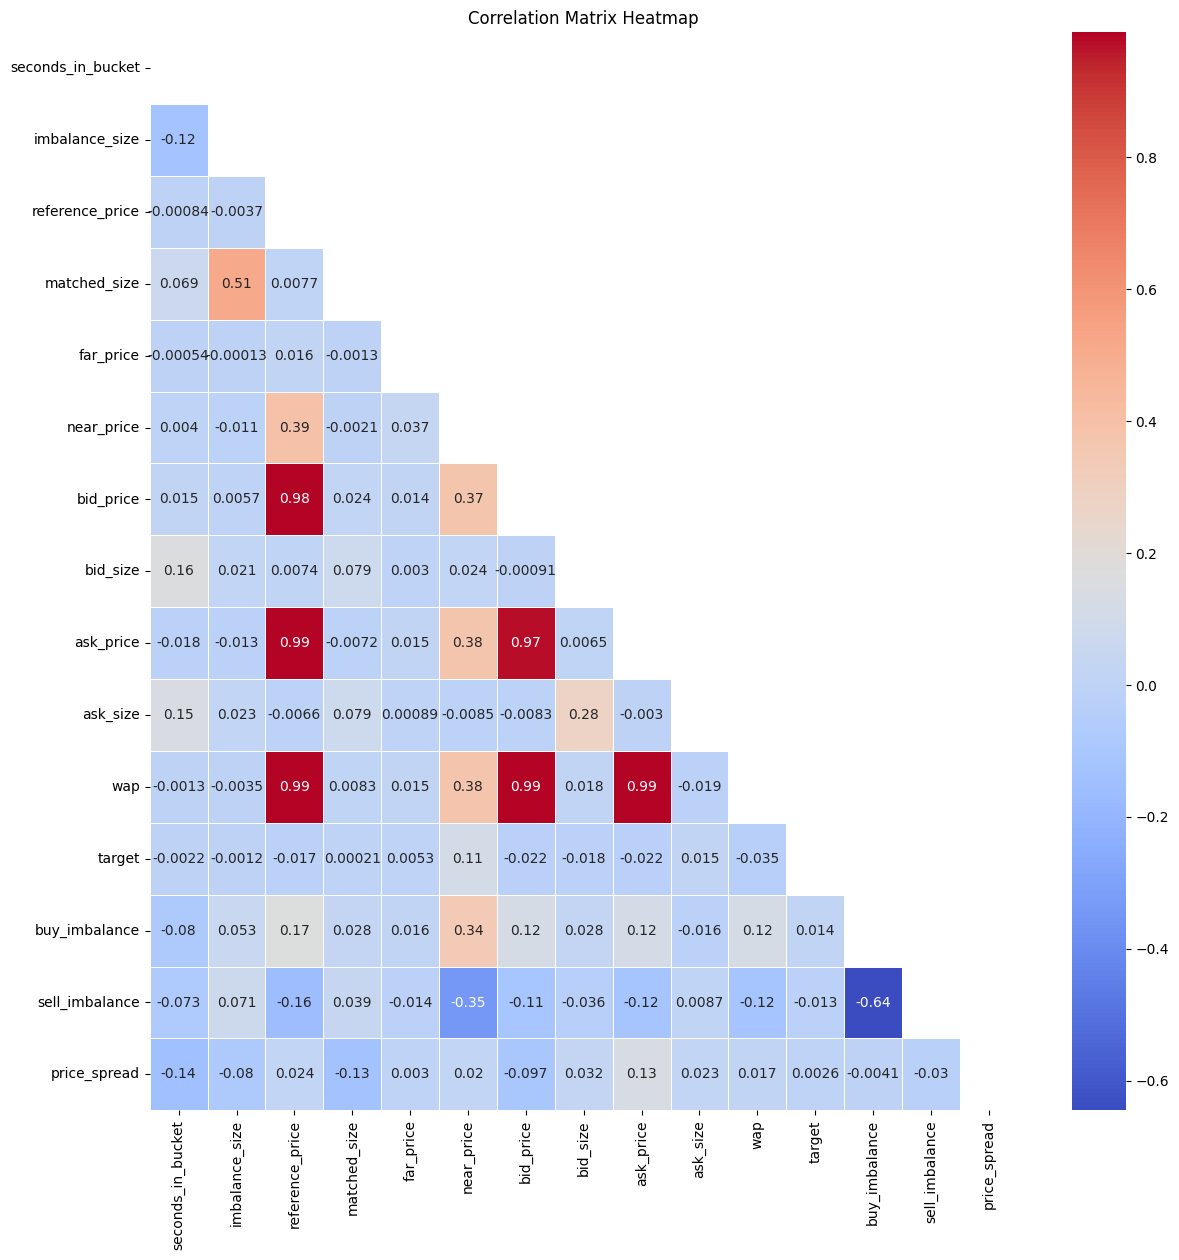

In [ ]:
"""
For the processed dataset, with forward filled missing values and one-hot-encoding of the imbalance_flag
In the previous correlation map, we were able to see mild to moderate correlation between the imbalance flag and some of the features - near_price, ask_size, etc.
But since the imbalance_flag has no numerical significance and is only present to represent the direction of imbalance in the market, these correlation values don't have a lot of meaning.
In the below map however, better relationships between buyer-side imbalance, seller-side imbalance and the features are exposed.
"""

pearson_correlation_stats(csv.drop(['row_id', 'stock_id', 'time_id', 'date_id'], axis=1))

In [ ]:
# Freeing up memory
del old_csv
del result
del grouped

In [ ]:
def plot_random_timeseries(df, cols):
  stock_id = np.random.randint(low=0, high=200)
  date_id = np.random.randint(low=0, high=480)
  return (df
      .query(f'stock_id == {stock_id} & date_id == {date_id}')
      .loc[:, ['seconds_in_bucket'] + cols]
      .set_index('seconds_in_bucket')
      .plot(title=f'Stock {stock_id} on Day {date_id}', figsize=(10, 4), linewidth=1)
    )

<Axes: title={'center': 'Stock 180 on Day 129'}, xlabel='seconds_in_bucket'>

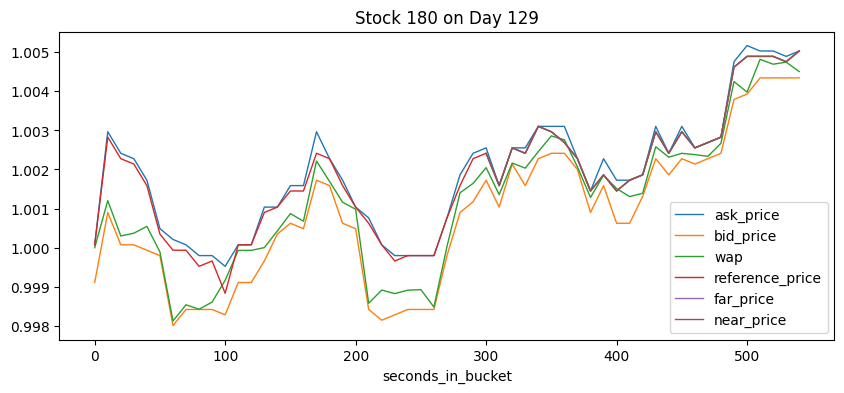

In [ ]:
plot_random_timeseries(csv, ['ask_price', 'bid_price', 'wap', 'reference_price', 'far_price', 'near_price'])

### Correlated features:
#### bid_price, ask_price, wap, ref_price:
All of the above are mutually very highly correlated [0.97,0.99]. This is expected. Here's why:
1. Bid price and ask price depend on the current estimate of the value of the stock among the buyers and sellers. The sellers and buyers have to meet their expectations at one value for the market to keep going. Or else, no transaction will be able to take place. If sellers' best ask price increases, then the buyers will have to increase their bid price to buy the stock. Similarly, if there is a lot of demand and the buyers' best bid price increases, sellers will start asking for more.
2. wap is a weighted average of the bid_price and ask_price. In the above graph, you can see that wap always lies between the bid_price and sell_price for any given stock. So it follows that when bid_price, ask_price and wap follow the same trends.
3. reference_price is the price at which paired shares are maximized, the imbalance is minimized and the distance from the bid-ask midpoint is minimized, in that order. Can also be thought of as being equal to the near price bounded between the best bid and ask price. (definition from the Optiver dataset description). In simple terms, it is the price that is most agreeable to both the sellers and the buyers, so if the ask price and bid price increase(/decrease) it naturally follows that the reference price increases(/decreases). Therefore, it is also highly correlated with the above price points.

#### Other interesting correlations:
1. When there is a buyer-side imbalance, all the price points tend to increase.
This is because when there is a buyer-side imbalance, it represents a huge demand for the stock. There are more buyers than what has been matched. So sellers increase the size, knowing there is demand.
Similarly, when there is a seller-side imbalance, price points tend to decrease. It follows the same principle but the other way round. There is too much supply, but not enough demand.
2. The time features have been dropped for the second plot except seconds_in_bucket - just to show that as more time passes, the ask_size and bid_size grow in the market and the imbalance_size reduces. This shows that buyers and sellers slowly come to matching terms within the closing window.

#### Average records stockID vs Day
Distance function between entries
- a. autocorrelation
- b. measure the distance
- c. clustering algorithm



In [ ]:
columns_to_scale = ['ask_size', 'bid_size', 'far_price', 'imbalance_size', 'matched_size', 'price_spread']

scaler = MinMaxScaler()

scaled_data = csv.copy()

scaled_data[columns_to_scale] = scaler.fit_transform(csv[columns_to_scale])

print(scaled_data.describe())

grouped = scaled_data.groupby(['stock_id', 'date_id'])

           stock_id       date_id  seconds_in_bucket  imbalance_size  \
count  5.236660e+06  5.236660e+06       5.236660e+06    5.236660e+06   
mean   9.929086e+01  2.414930e+02       2.700000e+02    1.916921e-03   
std    5.787308e+01  1.385219e+02       1.587451e+02    6.880530e-03   
min    0.000000e+00  0.000000e+00       0.000000e+00    0.000000e+00   
25%    4.900000e+01  1.220000e+02       1.300000e+02    2.832648e-05   
50%    9.900000e+01  2.420000e+02       2.700000e+02    3.735642e-04   
75%    1.490000e+02  3.610000e+02       4.100000e+02    1.405666e-03   
max    1.990000e+02  4.800000e+02       5.400000e+02    1.000000e+00   

       reference_price  matched_size     far_price    near_price  \
count     5.236660e+06  5.236660e+06  5.236660e+06  5.236660e+06   
mean      9.999954e-01  5.847444e-03  2.289924e-03  9.996597e-01   
std       2.531648e-03  1.813071e-02  1.373008e-03  1.117892e-02   
min       9.352850e-01  0.000000e+00  0.000000e+00  7.869880e-01   
25%       9

In [ ]:
cols = ['ask_price', 'bid_price', 'reference_price', 'wap', 'matched_size', 'imbalance_size', 'buy_imbalance', 'sell_imbalance']

aggregation_functions = {
    'ask_price': 'last',
    'bid_price': 'last',
    'reference_price': 'last',
    'wap': 'last',
    'matched_size': 'last',
    'imbalance_size': 'last',
    'buy_imbalance': 'last',
    'sell_imbalance': 'last',
}

# Apply the aggregation functions to create the consensus record
consensus_df = grouped.agg(aggregation_functions).reset_index()

In [ ]:
lag_range = range(-10, 11)

stockday_consensus = consensus_df.groupby('stock_id')

autocorrelation_data = []
count = 0

# Iterate through each stock group
for stock_id, group in stockday_consensus:
    # Calculating the pearson_correlation as the distance between two records
    average_distances = []
    for lag in lag_range:
        distances = group[cols].corrwith(group[cols].shift(lag), axis=1)
        average_distance = distances.mean()
        autocorrelation_data.append({"stock_id": stock_id, "lag": lag, "autocorrelation": average_distance})

autocorrelation_results = pd.DataFrame(autocorrelation_data)

In [ ]:
# Initial inspection
"""
Days immediately before and after the current day are more closely correlated.
The correlation wanes as we move away from the current day.
"""

random_record = autocorrelation_results[autocorrelation_results['stock_id'] == np.random.randint(low=0, high=199)]

lag_corr = autocorrelation_results.groupby(['lag'])['autocorrelation'].mean()

print(random_record)
print("Average lag correlation: ")
print(lag_corr)

      stock_id  lag  autocorrelation
2751       131  -10         0.800373
2752       131   -9         0.819295
2753       131   -8         0.804469
2754       131   -7         0.814000
2755       131   -6         0.811010
2756       131   -5         0.813829
2757       131   -4         0.801148
2758       131   -3         0.810321
2759       131   -2         0.811084
2760       131   -1         0.829875
2761       131    0         1.000000
2762       131    1         0.829875
2763       131    2         0.811084
2764       131    3         0.810321
2765       131    4         0.801148
2766       131    5         0.813829
2767       131    6         0.811010
2768       131    7         0.814000
2769       131    8         0.804469
2770       131    9         0.819295
2771       131   10         0.800373
Average lag correlation: 
lag
-10    0.799312
-9     0.798123
-8     0.797939
-7     0.799501
-6     0.798201
-5     0.801876
-4     0.804119
-3     0.803569
-2     0.808529
-1     0.818

In [ ]:
stock_consensus = consensus_df.groupby('stock_id').mean()
print(stock_consensus)

          date_id  ask_price  bid_price  reference_price       wap  \
stock_id                                                             
0           240.0   0.999906   0.999745         0.999818  0.999819   
1           240.0   1.000295   0.999637         0.999950  0.999964   
2           240.0   1.000512   0.999828         1.000176  1.000158   
3           240.0   1.000053   0.999907         0.999978  0.999977   
4           240.0   0.999943   0.999762         0.999845  0.999849   
...           ...        ...        ...              ...       ...   
195         240.0   0.999912   0.999779         0.999838  0.999842   
196         240.0   1.000299   1.000035         1.000163  1.000163   
197         240.0   1.000314   1.000077         1.000192  1.000193   
198         240.0   0.999911   0.999669         0.999790  0.999787   
199         284.0   1.000402   1.000048         1.000210  1.000219   

          matched_size  imbalance_size  buy_imbalance  sell_imbalance  
stock_id         

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

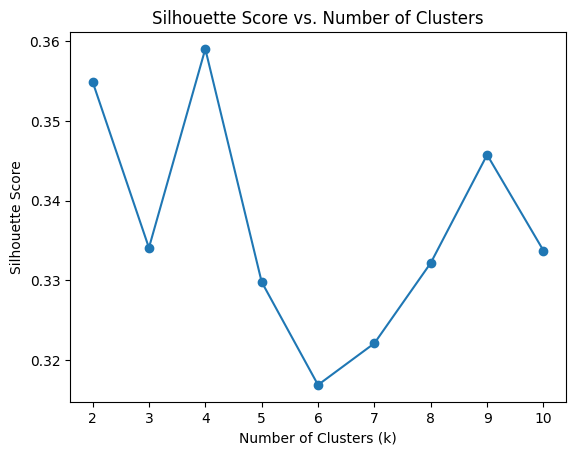

Optimal number of clusters: 4


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


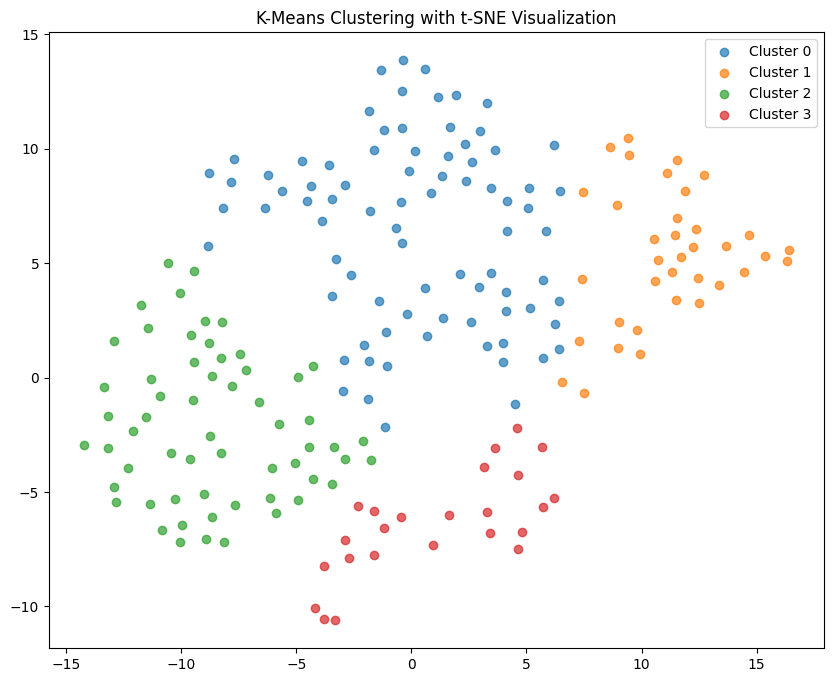

In [ ]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

X = stock_consensus[cols]

silhouette_scores = []

# Define a range of values for k (number of clusters)
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k)
    cluster_labels = kmeans.fit_predict(X)

    # Calculate the silhouette score
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot the silhouette scores to help determine the optimal number of clusters
plt.plot(k_range, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.show()

# Find the optimal number of clusters (k) based on the plot or other methods
optimal_k = k_range[np.argmax(silhouette_scores)]
print("Optimal number of clusters:", optimal_k)

# Now, you can use this optimal number to perform K-Means clustering
kmeans = KMeans(n_clusters=optimal_k)
stock_consensus['cluster'] = kmeans.fit_predict(X)

# Reduce dimensionality using t-SNE for visualization
tsne = TSNE(n_components=2, perplexity=30, random_state=0)
X_tsne = tsne.fit_transform(X)

# Create a scatter plot of the clustered data
plt.figure(figsize=(10, 8))
for i in range(optimal_k):
    plt.scatter(
        X_tsne[stock_consensus['cluster'] == i][:, 0],
        X_tsne[stock_consensus['cluster'] == i][:, 1],
        label=f'Cluster {i}',
        alpha=0.7
    )

plt.legend()
plt.title('K-Means Clustering with t-SNE Visualization')
plt.show()

#### Closing trajectory of stocks on each day highly correlated
- a. Three interesting plots
- b. Permutation test for statistical confidence, p-value


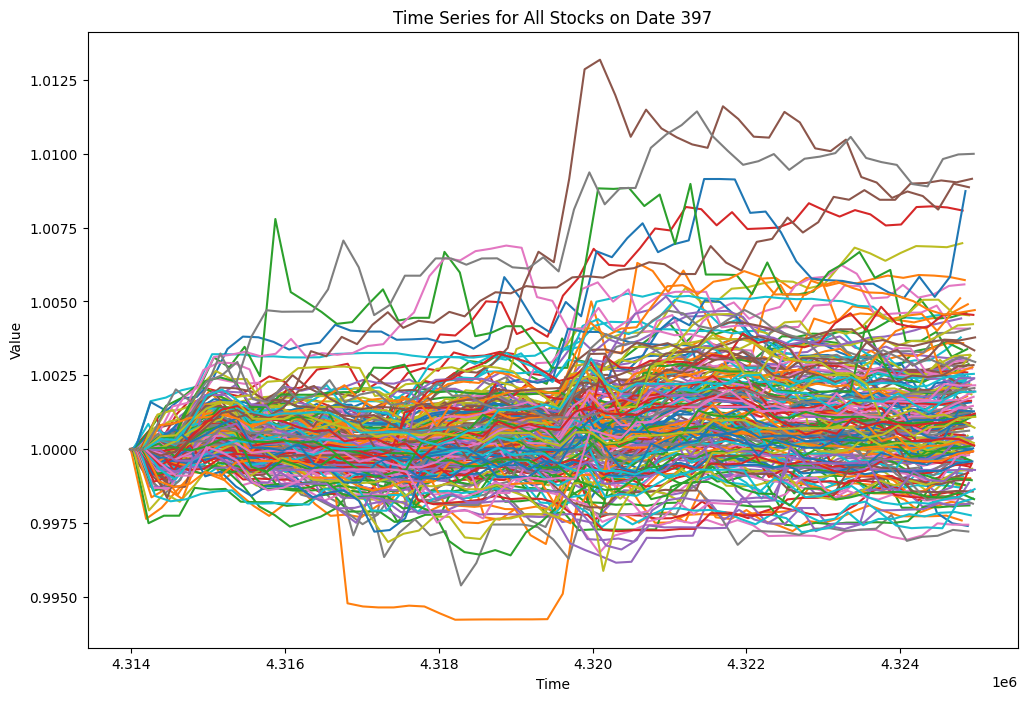

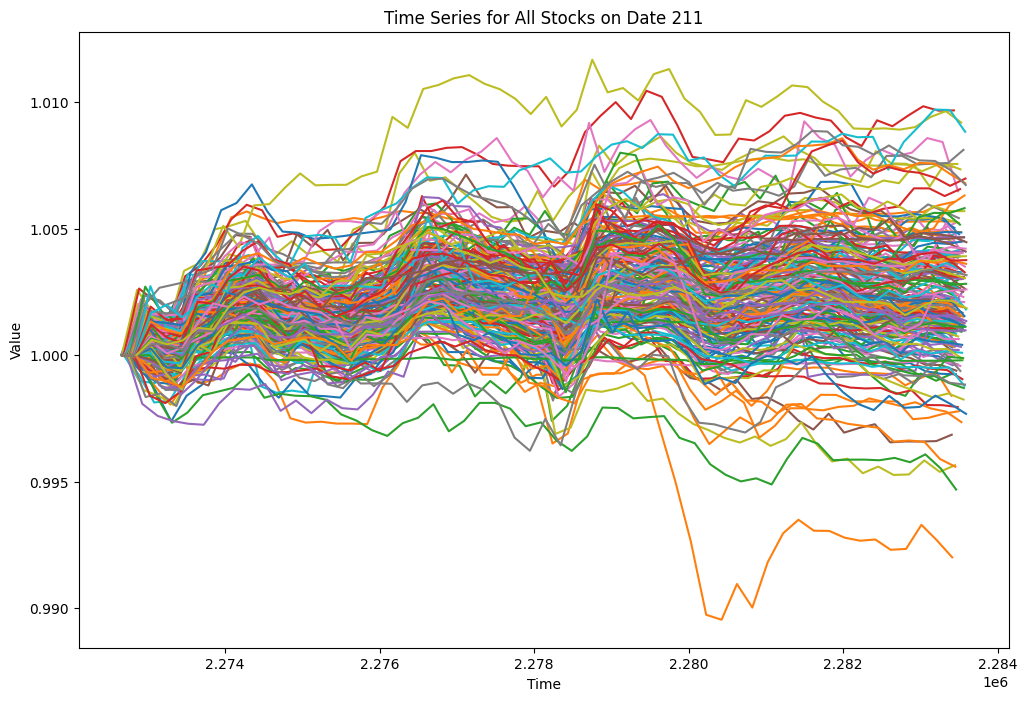

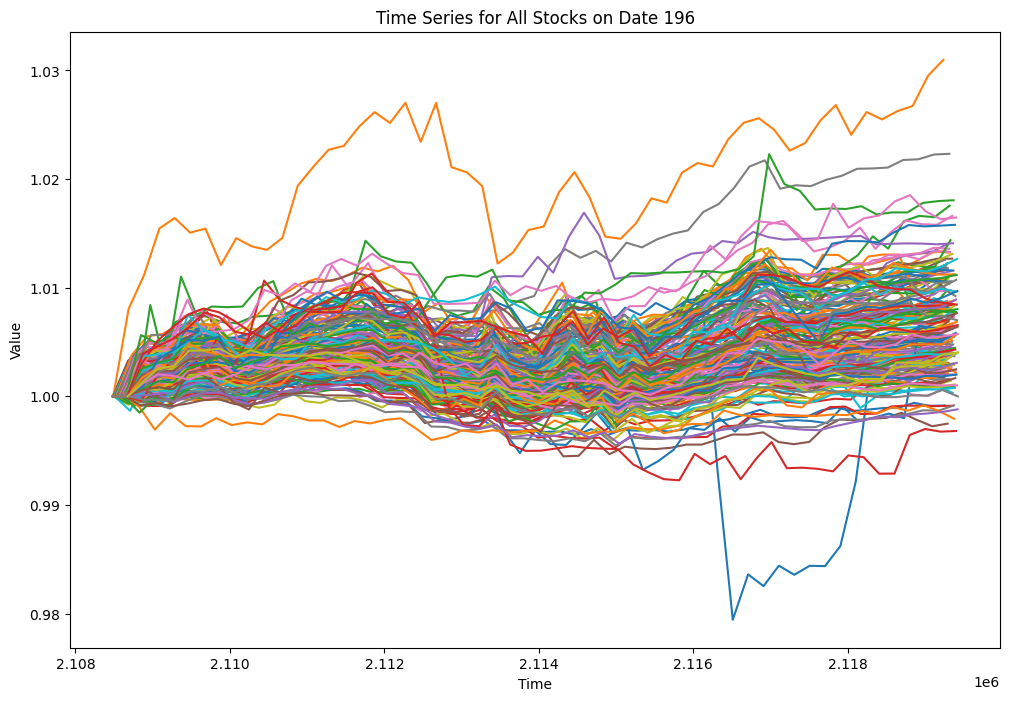

In [ ]:
def plot_random_day(df, col):
  date_id_to_plot = np.random.randint(low=0, high=480)

  # Filter the dataset for the selected date_id
  date_data = df[df['date_id'] == date_id_to_plot]

  # Create a figure and axis for the subplots
  fig, ax = plt.subplots(figsize=(12, 8))

  for stock_id, group in date_data.groupby('stock_id'):
      # Plot the time series for the current stock
      ax.plot(group[col], label=f'Stock {stock_id}')

  ax.set_xlabel('Time')
  ax.set_ylabel('Value')
  ax.set_title(f'Time Series for All Stocks on Date {date_id_to_plot}')

  plt.show()


for i in range(3):
  plot_random_day(csv, "wap")

In [ ]:
"""
Metric: median wap
Null hypothesis: The stock prices depend on supply and demand. The median wap for stocks do not correlate within a day.
Alternative hypothesis: There are up and down days, and the median wap for all stocks on a given day will be close.
"""

stock_sec_grouped = csv.groupby(['stock_id', 'seconds_in_bucket'])
sampled = stock_sec_grouped.sample(n=400, replace=True)
sampled_medians = sampled.groupby('seconds_in_bucket')['wap'].median()

ordered = stock_sec_grouped.head(n=10)
ordered_medians = ordered.groupby(['date_id','seconds_in_bucket'])['wap'].median()

In [ ]:
from scipy.stats import mannwhitneyu

# Perform the Mann-Whitney U test
statistic, p_value = mannwhitneyu(ordered_medians, sampled_medians, alternative='two-sided')

# Print the results
print(f"Test Statistic: {statistic}")
print(f"P-Value: {p_value}")

if p_value < 0.05:
    print("The difference is statistically significant.")
else:
    print("The difference is not statistically significant.")

Test Statistic: 137500.0
P-Value: 0.2936529510625684
The difference is not statistically significant.


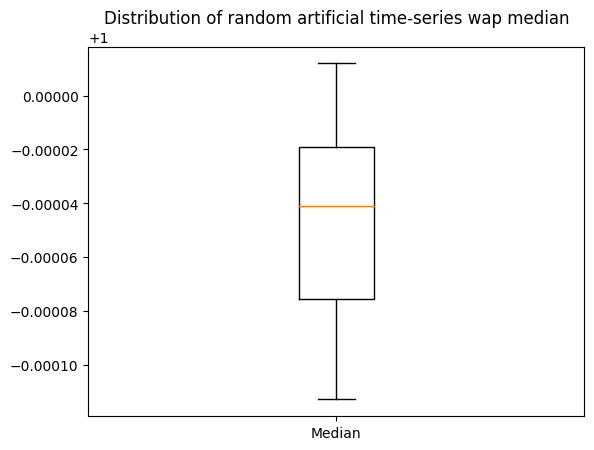

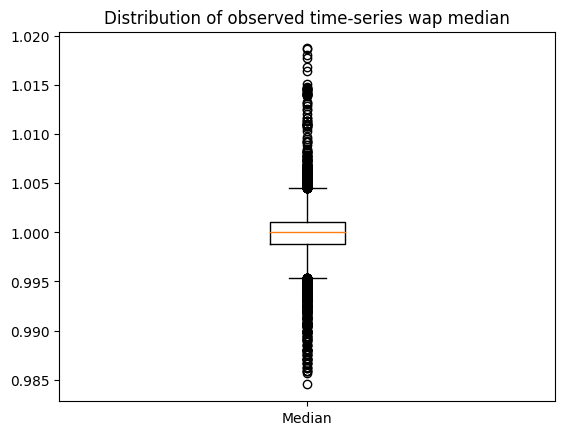

In [ ]:
def distribution_stats(data, title):
  plt.boxplot(data)
  plt.title(title)
  plt.xticks([1], ["Median"])
  plt.show()

distribution_stats(sampled_medians.values, 'Distribution of random artificial time-series wap median')
distribution_stats(ordered_medians.values, 'Distribution of observed time-series wap median')

#### Prediction models


In [ ]:
X_train = csv.drop(['row_id', "time_id", "target"], axis=1)
Y_train = csv['target']

In [ ]:
def fold5_cross_validation(model, X, Y):
  # Set up K-Fold cross-validation with 5 folds
  # Not shuffling to keep the time series order intact
  kf = KFold(n_splits=5)

  # Perform 5-fold cross-validation and calculate mean absolute error (MAE)
  mae_scores = -cross_val_score(model, X, Y, cv=kf, scoring='neg_mean_absolute_error')

  # Calculate the average MAE
  average_mae = np.mean(mae_scores)

  print("Mean Absolute Error (MAE) Scores:", mae_scores)
  print("Average MAE:", average_mae)

In [ ]:
baseline_model = LinearRegression()
fold5_cross_validation(baseline_model, X_train, Y_train)

Mean Absolute Error (MAE) Scores: [5.72222495 7.07251648 6.3413685  6.3452871  5.99193883]
Average MAE: 6.294667172283011


In [ ]:
"""
Attempt to see if winsorzing the outliers in the data gives better results.
"""

columns_to_scale = ['ask_size', 'bid_size', 'far_price', 'imbalance_size', 'matched_size']

# Set the lower and upper percentile thresholds
lower_percentile = 0.01  # The 5th percentile
upper_percentile = 0.99  # The 95th percentile

X_without_outliers = X_train.copy()

# Apply winsorization to the specified columns
X_without_outliers[columns_to_scale] = X_train[columns_to_scale].apply(
    lambda column: mstats.winsorize(column, limits=(lower_percentile, upper_percentile))
)

X_without_outliers.describe()

,unique,cardinality,null_ct,null_pct,1st_row,random_row,last_row,min,1%,10%,25%,50%,75%,90%,99%,max,dtype
stock_id,False,200,0,0.0,0.000000,151.000000,199.000000,0.000000,1.000000,19.000000,49.000000,99.000000,149.000000,180.000000,197.000000,199.000000,int64
date_id,False,481,0,0.0,0.000000,92.000000,480.000000,0.000000,4.000000,49.000000,122.000000,242.000000,361.000000,433.000000,476.000000,480.000000,int64
seconds_in_bucket,False,55,0,0.0,0.000000,210.000000,540.000000,0.000000,0.000000,50.000000,130.000000,270.000000,410.000000,490.000000,540.000000,540.000000,int64
imbalance_size,False,1,0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,float64
reference_price,False,28722,0,0.0,0.999812,0.998736,1.002129,0.935285,0.993299,0.997249,0.998763,0.999967,1.001174,1.002740,1.007181,1.077488,float64
matched_size,False,1,0,0.0,467986.730000,467986.730000,467986.730000,467986.730000,467986.730000,467986.730000,467986.730000,467986.730000,467986.730000,467986.730000,467986.730000,467986.730000,float64
far_price,False,1,0,0.0,0.949310,0.949310,0.949310,0.949310,0.949310,0.949310,0.949310,0.949310,0.949310,0.949310,0.949310,0.949310,float64
near_price,False,176247,0,0.0,0.999615,0.994587,1.001494,0.786988,0.964305,0.990215,0.996762,0.999874,1.002844,1.008712,1.033486,1.309732,float64
bid_price,False,28298,0,0.0,0.999812,0.998736,1.002129,0.934915,0.992993,0.997000,0.998529,0.999728,1.000905,1.002420,1.006705,1.077488,float64
bid_size,False,1,0,0.0,165.640000,165.640000,165.640000,165.640000,165.640000,165.640000,165.640000,165.640000,165.640000,165.640000,165.640000,165.640000,float64


In [ ]:
model2 = LinearRegression()
fold5_cross_validation(model2, X_without_outliers, Y_train)

Mean Absolute Error (MAE) Scores: [6.27817255 6.29639515 6.29647663 6.29061893 6.29383005]
Average MAE: 6.291098663916583


In [ ]:
"""
Attempt to see if scaled features work better.
"""

columns_to_scale = ['ask_size', 'bid_size', 'far_price', 'imbalance_size', 'matched_size', 'price_spread']

scaler = RobustScaler()

scaled_data = X_train.copy()
scaled_data[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])

model3 = LinearRegression()
fold5_cross_validation(model3, scaled_data, Y_train)

In [ ]:
"""
Passing grouped data
"""

grouped_data = csv.groupby(['stock_id', 'date_id'], group_keys=False).apply(lambda x: x.sort_values(by=['seconds_in_bucket']))

model4 = LinearRegression()
fold5_cross_validation(model4, grouped_data[X_train.columns], grouped_data['target'])

Mean Absolute Error (MAE) Scores: [5.72222495 7.07251648 6.3413685  6.3452871  5.99193883]
Average MAE: 6.294667172283011


In [ ]:
"""
Using XGBoost model
"""

import xgboost as xgb

params = {
    'objective': 'reg:squarederror',  # For regression tasks
    'max_depth': 3,  # Maximum depth of the trees
    'n_estimators': 200,  # Number of boosting rounds
    'learning_rate': 0.5,
    'subsample': 0.8,  # Fraction of samples used for each boosting round
    'colsample_bytree': 0.8,  # Fraction of features used for each boosting round
    'random_state': 42
}

model5 = xgb.XGBRegressor(**params)
fold5_cross_validation(model5, X_train, Y_train)

Mean Absolute Error (MAE) Scores: [5.58973562 6.93718557 6.20321089 6.19745987 5.79571719]
Average MAE: 6.14466182967358


##References:

### Pandas:
1. Quantile: https://stackoverflow.com/questions/39581893/find-percentile-stats-of-a-given-column
2. Group-by count: https://sparkbyexamples.com/pandas/pandas-groupby-count-examples/
3. Group-by fill: https://stackoverflow.com/questions/19966018/pandas-filling-missing-values-by-mean-in-each-group
4. https://www.geeksforgeeks.org/how-to-replace-values-in-column-based-on-condition-in-pandas/
5. Correlation: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html
6. Heatmap: https://www.geeksforgeeks.org/how-to-create-a-seaborn-correlation-heatmap-in-python/
7. https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corrwith.html

### Domain:
1. https://www.kaggle.com/competitions/optiver-trading-at-the-close/discussion/441966
2. https://www.investopedia.com/terms/b/bid-and-ask.asp